### Import Packages

In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import torch
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig, TrainingArguments, Trainer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.nn import BCEWithLogitsLoss


### Image and Labels Loading and Matching

In [2]:
# Load the Data from CSV
csv_file = "clean_MovieGenre.csv"  # Path to your CSV file
df = pd.read_csv(csv_file)

# Specify the binarized columns
binarized_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 
                     'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 
                     'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']

# Define a custom dataset class
class MovieGenreDataset(Dataset):
    def __init__(self, df, image_folder, binarized_columns, processor):
        self.df = df
        self.image_folder = image_folder
        self.binarized_columns = binarized_columns
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = str(row['imdbId']) + ".jpg"
        label = [int(row[column]) for column in self.binarized_columns]
        
        image_path = os.path.join(self.image_folder, filename)
        image = Image.open(image_path).convert("RGB")
        
        # Process the image
        inputs = self.processor(images=image, return_tensors="pt")
        processed_image = inputs.pixel_values.squeeze(0)  # Remove batch dimension
        
        label = torch.tensor(label).float()
        return processed_image, label

image_folder = "downloaded_images"  # Adjust this path as necessary


In [3]:
# Split the data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [4]:
# Display the column names to identify the correct column for IMDb IDs
print(df.columns)

Index(['imdbId', 'Title', 'Poster', 'Action', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western'],
      dtype='object')


### Sample Posters

c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data (

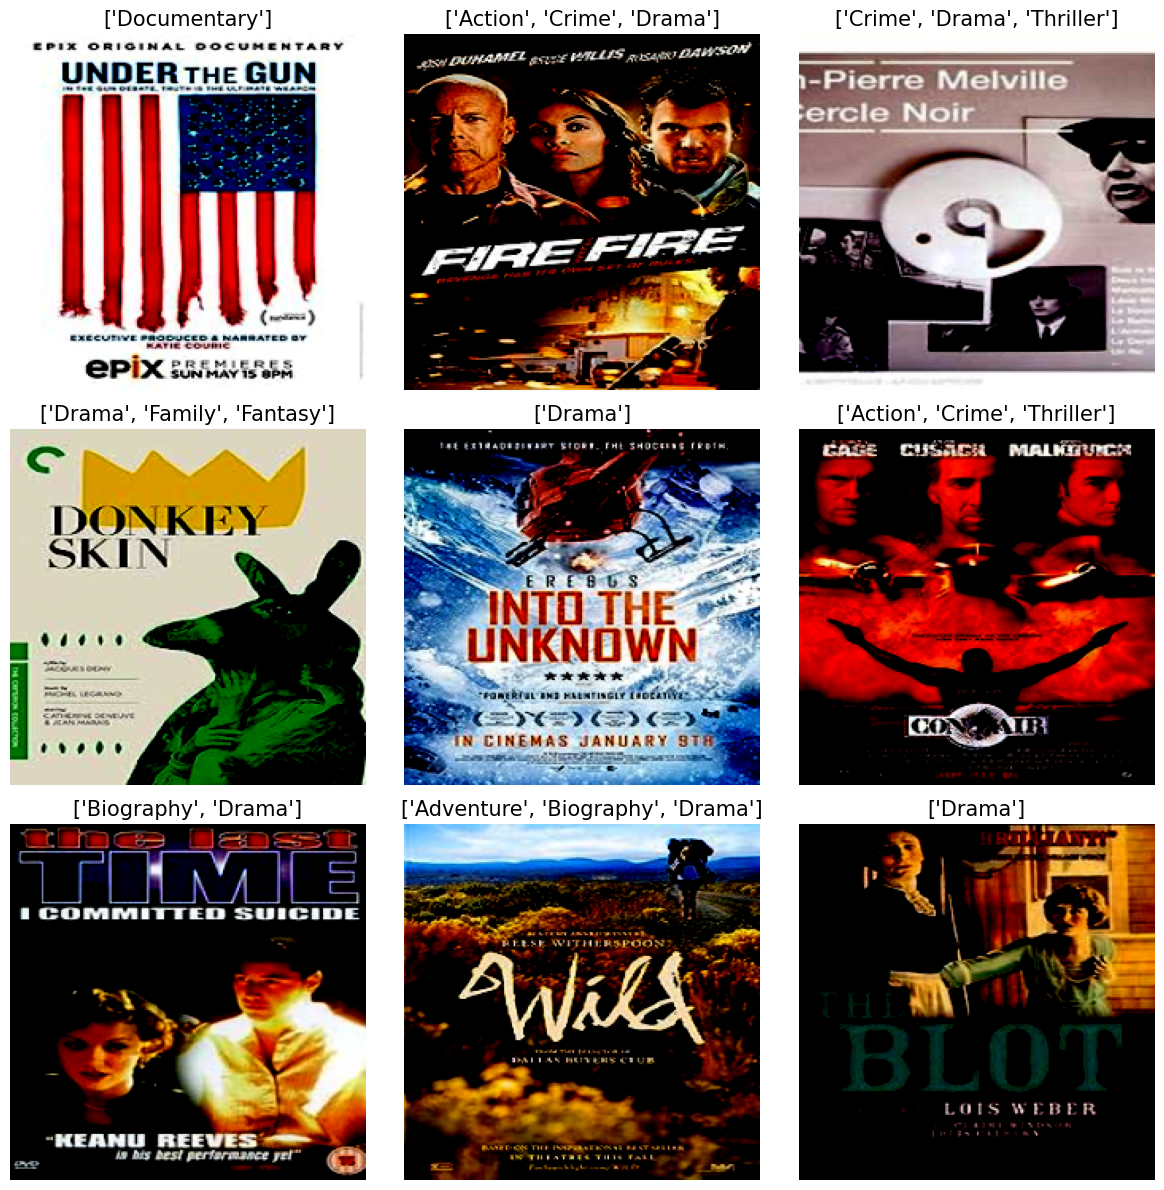

In [5]:
# Initialize processor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

# Create Dataset instances
train_dataset = MovieGenreDataset(train_df, image_folder, binarized_columns, processor)
val_dataset = MovieGenreDataset(val_df, image_folder, binarized_columns, processor)
test_dataset = MovieGenreDataset(test_df, image_folder, binarized_columns, processor)

# Increase batch size and number of workers
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=8)

# Display sample images
plt.figure(figsize=(12, 12))
for i in range(9):
    image, label = train_dataset[i]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title([column for column, lbl in zip(binarized_columns, label) if lbl == 1], fontsize=15)
plt.tight_layout()
plt.show()

### Preprocessing

In [6]:
# Print the shapes of the split datasets
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Testing dataset size:", len(test_dataset))

# Display distribution
train_label_distribution = np.sum([train_dataset[i][1].numpy() for i in range(len(train_dataset))], axis=0)
val_label_distribution = np.sum([val_dataset[i][1].numpy() for i in range(len(val_dataset))], axis=0)
test_label_distribution = np.sum([test_dataset[i][1].numpy() for i in range(len(test_dataset))], axis=0)

combined_data = {
    "Label": binarized_columns,
    "Train Distribution": train_label_distribution,
    "Validation Distribution": val_label_distribution,
    "Test Distribution": test_label_distribution
}

df_distribution = pd.DataFrame(combined_data)
print(df_distribution)


Training dataset size: 26620
Validation dataset size: 3328
Testing dataset size: 3327
          Label  Train Distribution  Validation Distribution  \
0        Action              3608.0                    431.0   
1     Adventure              2567.0                    308.0   
2     Animation              1189.0                    125.0   
3     Biography              1325.0                    192.0   
4        Comedy              8517.0                   1071.0   
5         Crime              3496.0                    407.0   
6   Documentary              2629.0                    361.0   
7         Drama             13432.0                   1641.0   
8        Family              1417.0                    166.0   
9       Fantasy              1365.0                    168.0   
10    Film-Noir               211.0                     31.0   
11      History               971.0                    136.0   
12       Horror              2646.0                    340.0   
13        Music   

### Modeling

In [7]:
# Load the default ViT model configuration
vit_config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')

# Update the image size in the configuration
vit_config = ViTConfig(
    image_size=(268, 182),
    problem_type="multi_label_classification",
    num_labels=len(binarized_columns),
    is_classifier=True,
    classifier_activation="sigmoid"
)

# Model Specification
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', config=vit_config, ignore_mismatched_sizes=True)

# Utilize GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print("Using device:", device)
model = model.to(device)


c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized because the shapes did not match:
- embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 177, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for pred

Using device: cuda


In [8]:
# Print out some samples from the DataLoader
for batch in train_dataloader:
    inputs, labels = batch["pixel_values"], batch["labels"]
    print("Input shape:", inputs.shape)
    print("Label shape:", labels.shape)
    break  # Print only the first batch


### Training

In [ ]:
# Mixed Precision and other training arguments
training_args = TrainingArguments(
    output_dir='output',
    per_device_train_batch_size=32,  # Increased batch size
    per_device_eval_batch_size=32,   # Increased batch size
    num_train_epochs=1,
    logging_dir='./logs',
    logging_steps=50,
    save_steps=200,
    evaluation_strategy="epoch",
    fp16=True,                      # Enable mixed precision training
    gradient_accumulation_steps=1,  # Update: no accumulation
    dataloader_num_workers=4,       # Increased number of workers for data loading
    learning_rate=1e-4,             # Adjusted learning rate
    weight_decay=0.01,
    save_total_limit=2,
)


def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids
    
    # Apply sigmoid to get probabilities
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()
    
    # Define a threshold to get binary predictions
    threshold = 0.5
    predictions = (probabilities > threshold).astype(int)
    
    f1 = f1_score(labels, predictions, average='micro')
    
    return {
        'f1_score': f1,
    }

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").float().to(model.device)  # Ensure labels are on the correct device
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# # Debug data loader outputs
# for step, inputs in enumerate(trainer.get_train_dataloader()):
#     print(f"Step {step} - Inputs: {inputs}")
#     if step > 1:  # Check only the first few steps
#         break

trainer.train()


### Testing

In [ ]:
# Ensure processor has the correct image size
processor.size = (268, 182)  # Set the processor size to match the model

# Perform inference
model.eval()
predicted_probabilities = []

for i, (batch_images, batch_labels) in enumerate(test_dataloader):
    batch_images = batch_images.to(device)
    with torch.no_grad():
        outputs = model(pixel_values=batch_images)
        logits = outputs.logits
        probabilities = torch.sigmoid(logits)
        predicted_probabilities.append(probabilities.cpu().numpy())

# Concatenate predicted probabilities for all batches
predicted_probabilities = np.concatenate(predicted_probabilities, axis=0)


### Evaluation

In [ ]:
# Convert lists to NumPy arrays
y_test_np = np.array([y.numpy() for x, y in test_dataset])
predicted_probabilities_np = np.array(predicted_probabilities)

# Ensure that the arrays have the appropriate shape
y_test_np = np.vstack([np.array(y) for y in y_test_np])

# Define the threshold for binary classification
threshold = 0.5

# Threshold predicted probabilities to obtain binary predictions
predicted_labels_np = (predicted_probabilities_np > threshold).astype(int)

# Initialize lists to store F1 scores and accuracies for each label
f1_scores = []
accuracies = []
predicted_binary_labels = (predicted_probabilities_np > threshold).astype(int)

# Iterate over each label
for i, label in enumerate(binarized_columns):
    # Calculate F1 score
    f1 = f1_score(y_test_np[:, i], predicted_labels_np[:, i], average='binary')
    f1_scores.append(f1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test_np[:, i], predicted_binary_labels[:, i])
    accuracies.append(accuracy)

data = {
    "Label": binarized_columns,
    "F1 Score": f1_scores,
    "Accuracy": accuracies
}

df_metrics = pd.DataFrame(data)
print(df_metrics)

# Compute average F1 score
avg_f1_score = np.mean(f1_scores)
print("\nAverage F1 score:", avg_f1_score)

# Compute average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print("Average accuracy:", average_accuracy)

In [ ]:
def display(X_test, y_test, predicted_probabilities, binarized_columns, threshold=0.5):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(X_test):
            poster = X_test[idx].permute(1, 2, 0).numpy()  # Transpose back to (height, width, channels)
            true_labels = [binarized_columns[i] for i, label in enumerate(y_test[idx].numpy()) if label == 1]
            predicted_labels = [binarized_columns[i] for i, prob in enumerate(predicted_probabilities[idx]) if prob > threshold]
            
            ax.imshow(poster)
            ax.set_title(f"True: {true_labels}\nPred: {predicted_labels}", fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display random sample of test set results
random_indices = np.random.choice(len(test_dataset), size=9, replace=False)
X_test_sample = torch.stack([test_dataset[idx][0] for idx in random_indices])
y_test_sample = torch.stack([test_dataset[idx][1] for idx in random_indices])

display(X_test_sample, y_test_sample, predicted_probabilities[random_indices], binarized_columns, threshold=0.5)